# Transferred Cases

`Status_Notes` contains 'case transferred' or 'case is transferred'

One type of case has `Responsible_Agency` = '311 Supervisor Queue'.

Other cases have any other `Responsible_Agency`

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
# import matplotlib as mpl
import seaborn as sns
import os

# import statsmodels.formula.api as smf
# import statsmodels.tsa.api as smt
# import statsmodels.api as sm

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [ ]:
# # sns.set()
# sns.set_style("darkgrid")
# # sns.set_style("whitegrid")

# from cycler import cycler

# # SVDS colors
# # colors = ['#0055A7', '#2C3E4F', '#26C5ED', '#00cc66', '#D34100', '#ECEFF0','#FF9700', '#091D32']

# n = 20 # Number of colors
# #colors = [plt.get_cmap('jet')(1. * i/n) for i in range(n)]
# #colors = [plt.get_cmap('Set1')(1. * i/n) for i in range(n)]
# # set up some plotting defaults
# #plt.rcParams['axes.prop_cycle'] = cycler('color', colors)
# plt.rcParams['figure.figsize'] = (12, 8)
# plt.rcParams['font.size'] = 16
# plt.rcParams['xtick.labelsize'] = 14
# plt.rcParams['ytick.labelsize'] = 14
# plt.rcParams['axes.labelsize'] = 20
# plt.rcParams['axes.labelcolor'] = '#677385'
# plt.rcParams['axes.titlesize'] = 20
# plt.rcParams['lines.color'] = '#0055A7'
# plt.rcParams['lines.linewidth'] = 1.5
# plt.rcParams['text.color'] = '#677385'
# plt.rcParams['legend.fontsize'] = 16
# # plt.rcParams['axes.formatter.limits'] = -10, 10

# plt.rcParams.update()

# # # ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
# # ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# pd.set_option('display.float_format', lambda x: '%.3f' % x)
# np.set_printoptions(precision=5, suppress=True)
# pd.set_option('display.max_columns', 200)
# pd.set_option('display.max_rows', 200)

In [3]:
# infile = os.path.join(os.getenv('HOME'),'Desktop', '311', 'calls_census_tracts.csv')
# df = pd.read_csv(infile, header=0, index_col=0, parse_dates=[1, 2, 3])

In [4]:
# outfile = os.path.join(os.getenv('HOME'),'Desktop', '311', 'calls_census_tracts.p')
# df.to_pickle(outfile)

In [2]:
infile = os.path.join(os.getenv('HOME'),'Desktop', '311', 'calls_census_tracts.p')
df = pd.read_pickle(infile)

In [3]:
df.shape

(1594511, 23)

In [4]:
df.columns = [x.replace('.', '_') for x in df.columns]
df = df.drop(['Point', 'Media_URL', 'shape_area', 'shape_len', 'optional'], axis=1)

df['Status_Notes'] = df['Status_Notes'].astype('str').apply(lambda x: x.lower())

In [6]:
# only include the cases with Responsible_Agency = '311 Supervisor Queue'
df['invalid'] = df['Status_Notes'].apply(lambda x: x.find('case') >= 0) & df['Status_Notes'].apply(lambda x: x.find('invalid') >= 0) & (df['Responsible_Agency'] == '311 Supervisor Queue')
# include the cases with any mention of 'transferred' in Status_Notes
df['transferred'] = df['Status_Notes'].apply(lambda x: x.find('case') >= 0) & df['Status_Notes'].apply(lambda x: x.find('transferred') >= 0) & (df['Responsible_Agency'] == '311 Supervisor Queue')

# Investigate transfers

In [5]:
def plot_transfers(df, on_field='Responsible_Agency',
                   log=True,
                   min_n_trans=1, plot_top_n=50,
                   figsize=(30, 12), plot_square=True,
                   title_str=None,
                   verbose=False,
                  ):

    # set up fields to use
    # on_field = 'Responsible_Agency'
    # on_field = 'Category'
    # on_field = 'Request_Type'

    orig_field = 'orig'
    trans_field = 'trans'

    trans_id_field = 'CaseID_transf'
    
    if title_str is None:
        title_str = ''
    else:
        title_str = str(title_str)

    # find the case numbers that were transferred to by searching for a string of digits
    # TODO: this only keeps the first number found in status notes. Need to keep and check all numbers found.
    df_trans = df[df['transferred']]['Status_Notes'].str.extract('(?P<{}>\d+)'.format(trans_id_field), expand=True).dropna()
    df_trans[trans_id_field] = df_trans[trans_id_field].astype(int)

    # find and keep the cases that exist in the full data set
    trans_idx = set(df.index).intersection(set(df_trans[trans_id_field]))
    df_trans = df_trans[df_trans[trans_id_field].isin(trans_idx)]

    # sometimes the same number is found for the transferred case
    df_trans = df_trans[df_trans.index != df_trans[trans_id_field]]

    # overwrite index
    # trans_idx = df_trans.index

    # get information about the original case
    df_trans = df_trans.merge(df.ix[df_trans.index][[on_field]], left_index=True, right_index=True)
    df_trans = df_trans.rename(columns={on_field: orig_field})

    # get information about the case that it was transferred to
    df_trans = df_trans.merge(df.ix[df_trans[trans_id_field]][[on_field]], left_on=trans_id_field, right_index=True)
    df_trans = df_trans.rename(columns={on_field: trans_field})

    # count up the transitions
    df_counts = df_trans.groupby(by=[orig_field, trans_field]).count()
    df_counts = df_counts.rename(columns={trans_id_field: 'count'})
    df_counts = df_counts.sort_values(by='count', ascending=False)
    df_counts = df_counts.reset_index()

    # sort by number of cases
    orig_sort = df_counts.groupby(orig_field)['count'].sum().sort_values(ascending=False).index.tolist()
    trans_sort = df_counts.groupby(trans_field)['count'].sum().sort_values(ascending=False).index.tolist()
    
    if verbose:
        # print some stuff
        #print(df_counts.shape)
        #print(df_counts.head())
        print(df_counts[df_counts['count'] > 100])
        print(df_counts.groupby(orig_field)['count'].sum().ix[orig_sort[:20]])
        print(df_counts.groupby(trans_field)['count'].sum().ix[trans_sort[:20]])
    
    df_trans_matrix = df_counts[df_counts['count'] >= min_n_trans].pivot(index=orig_field, columns=trans_field, values='count').fillna(0).astype(int)

    # sort by the number of originating sources
    df_trans_matrix = df_trans_matrix.ix[orig_sort[:plot_top_n]].reindex_axis(trans_sort[:plot_top_n], axis=1)

    title_str = '{}311 Request Transfers by {}'.format(title_str, on_field)
    
    # plot it as a heatmap
    fig, ax = plt.subplots(figsize=figsize)
    if log:
        sns.heatmap(df_trans_matrix.apply(lambda x: np.log(x+1)), ax=ax, square=True);
        title_str = '{} (log transformed)'.format(title_str)
    else:
        sns.heatmap(df_trans_matrix, ax=ax, square=plot_square);

    ax.set_title(title_str);
    return df_counts

In [6]:
on_field = 'Responsible_Agency'
# on_field = 'Category'
# on_field = 'Status'

log=True
verbose=False

## All Queues

From 2008-03-20 11:48:32 to 2016-03-16 00:55:50:
For All Queues: 
62,269 / 1,594,511 cases are transferred (3.9%)


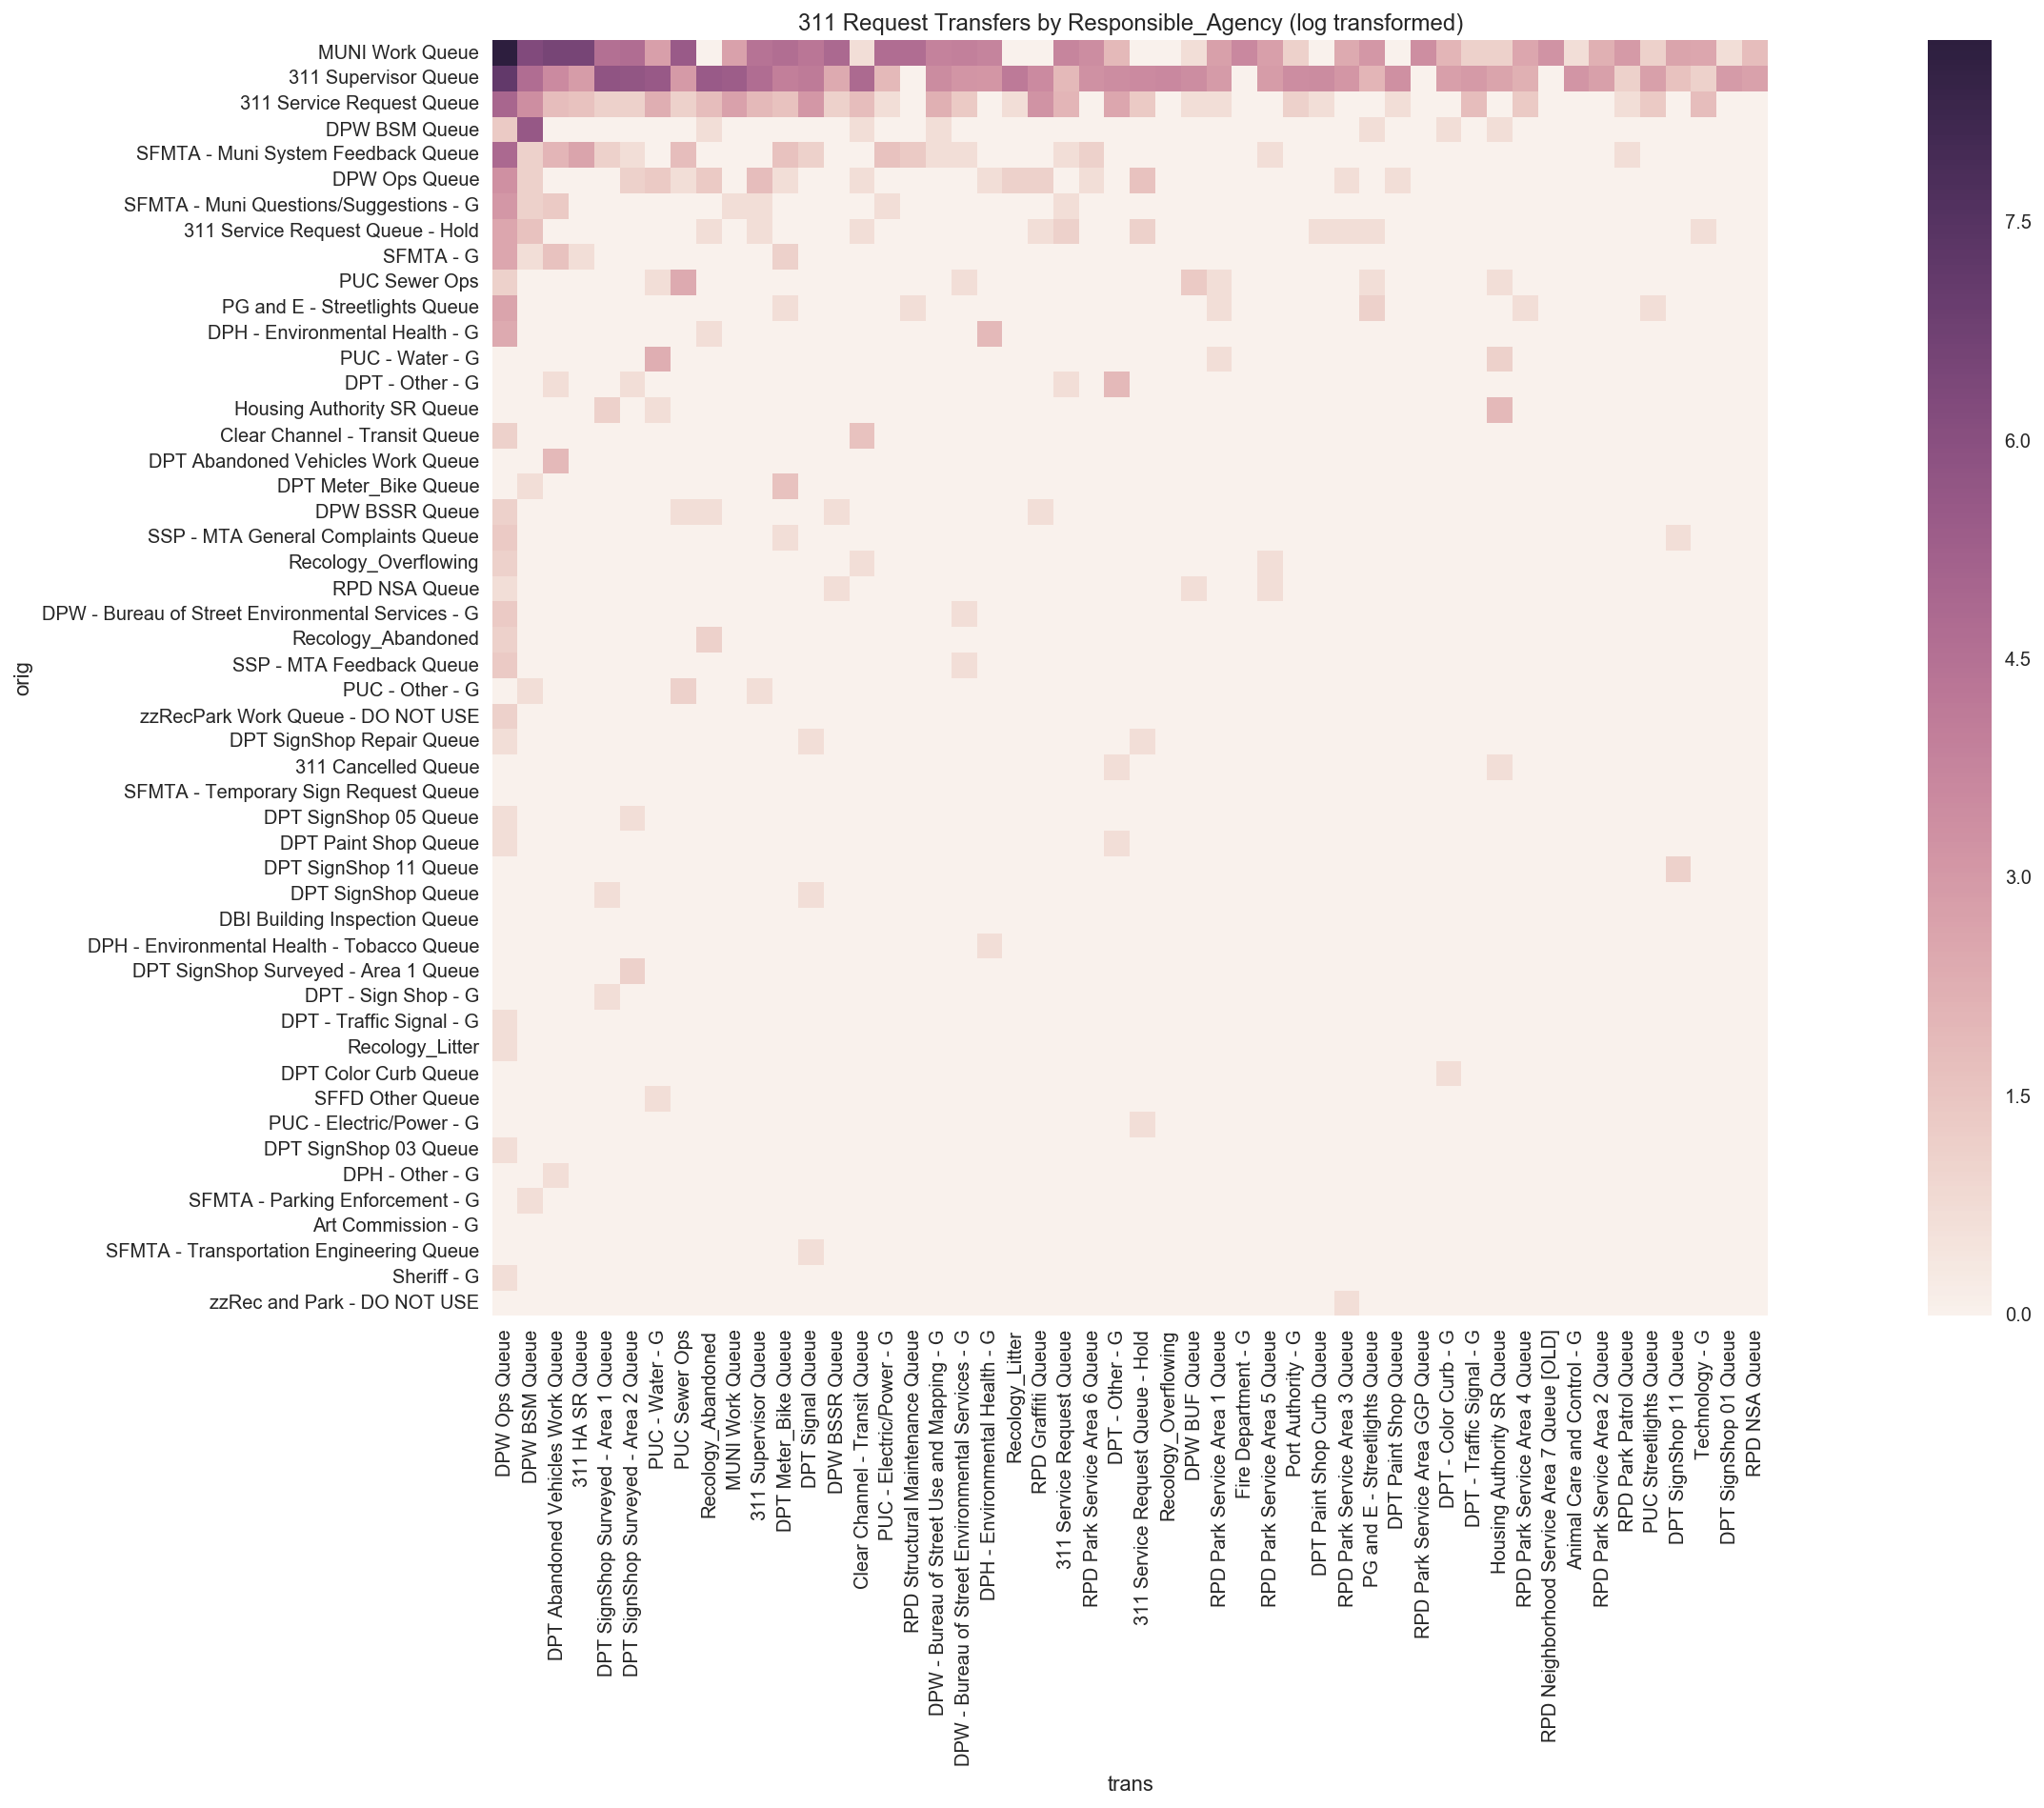

In [10]:
# all
df['transferred'] = df['Status_Notes'].apply(lambda x: x.find('tran') >= 0)
title_str=None

print('From {} to {}:'.format(df['Opened'].min(), df['Opened'].max()))
print('For {}'.format('All Queues: '))
print('{:,} / {:,} cases are transferred ({:.1f}%)'.format(df['transferred'].sum(), df.shape[0], (df['transferred'].sum()/df.shape[0])*100))

df_counts = plot_transfers(df, on_field=on_field,
                           log=log,
                           title_str=title_str,
                           verbose=verbose,
                           );

## Supervisor Queue

From 2008-03-20 11:48:32 to 2016-03-16 00:55:50:
For Supervisor Queue: 
6,529 / 1,594,511 cases are transferred (0.4%)


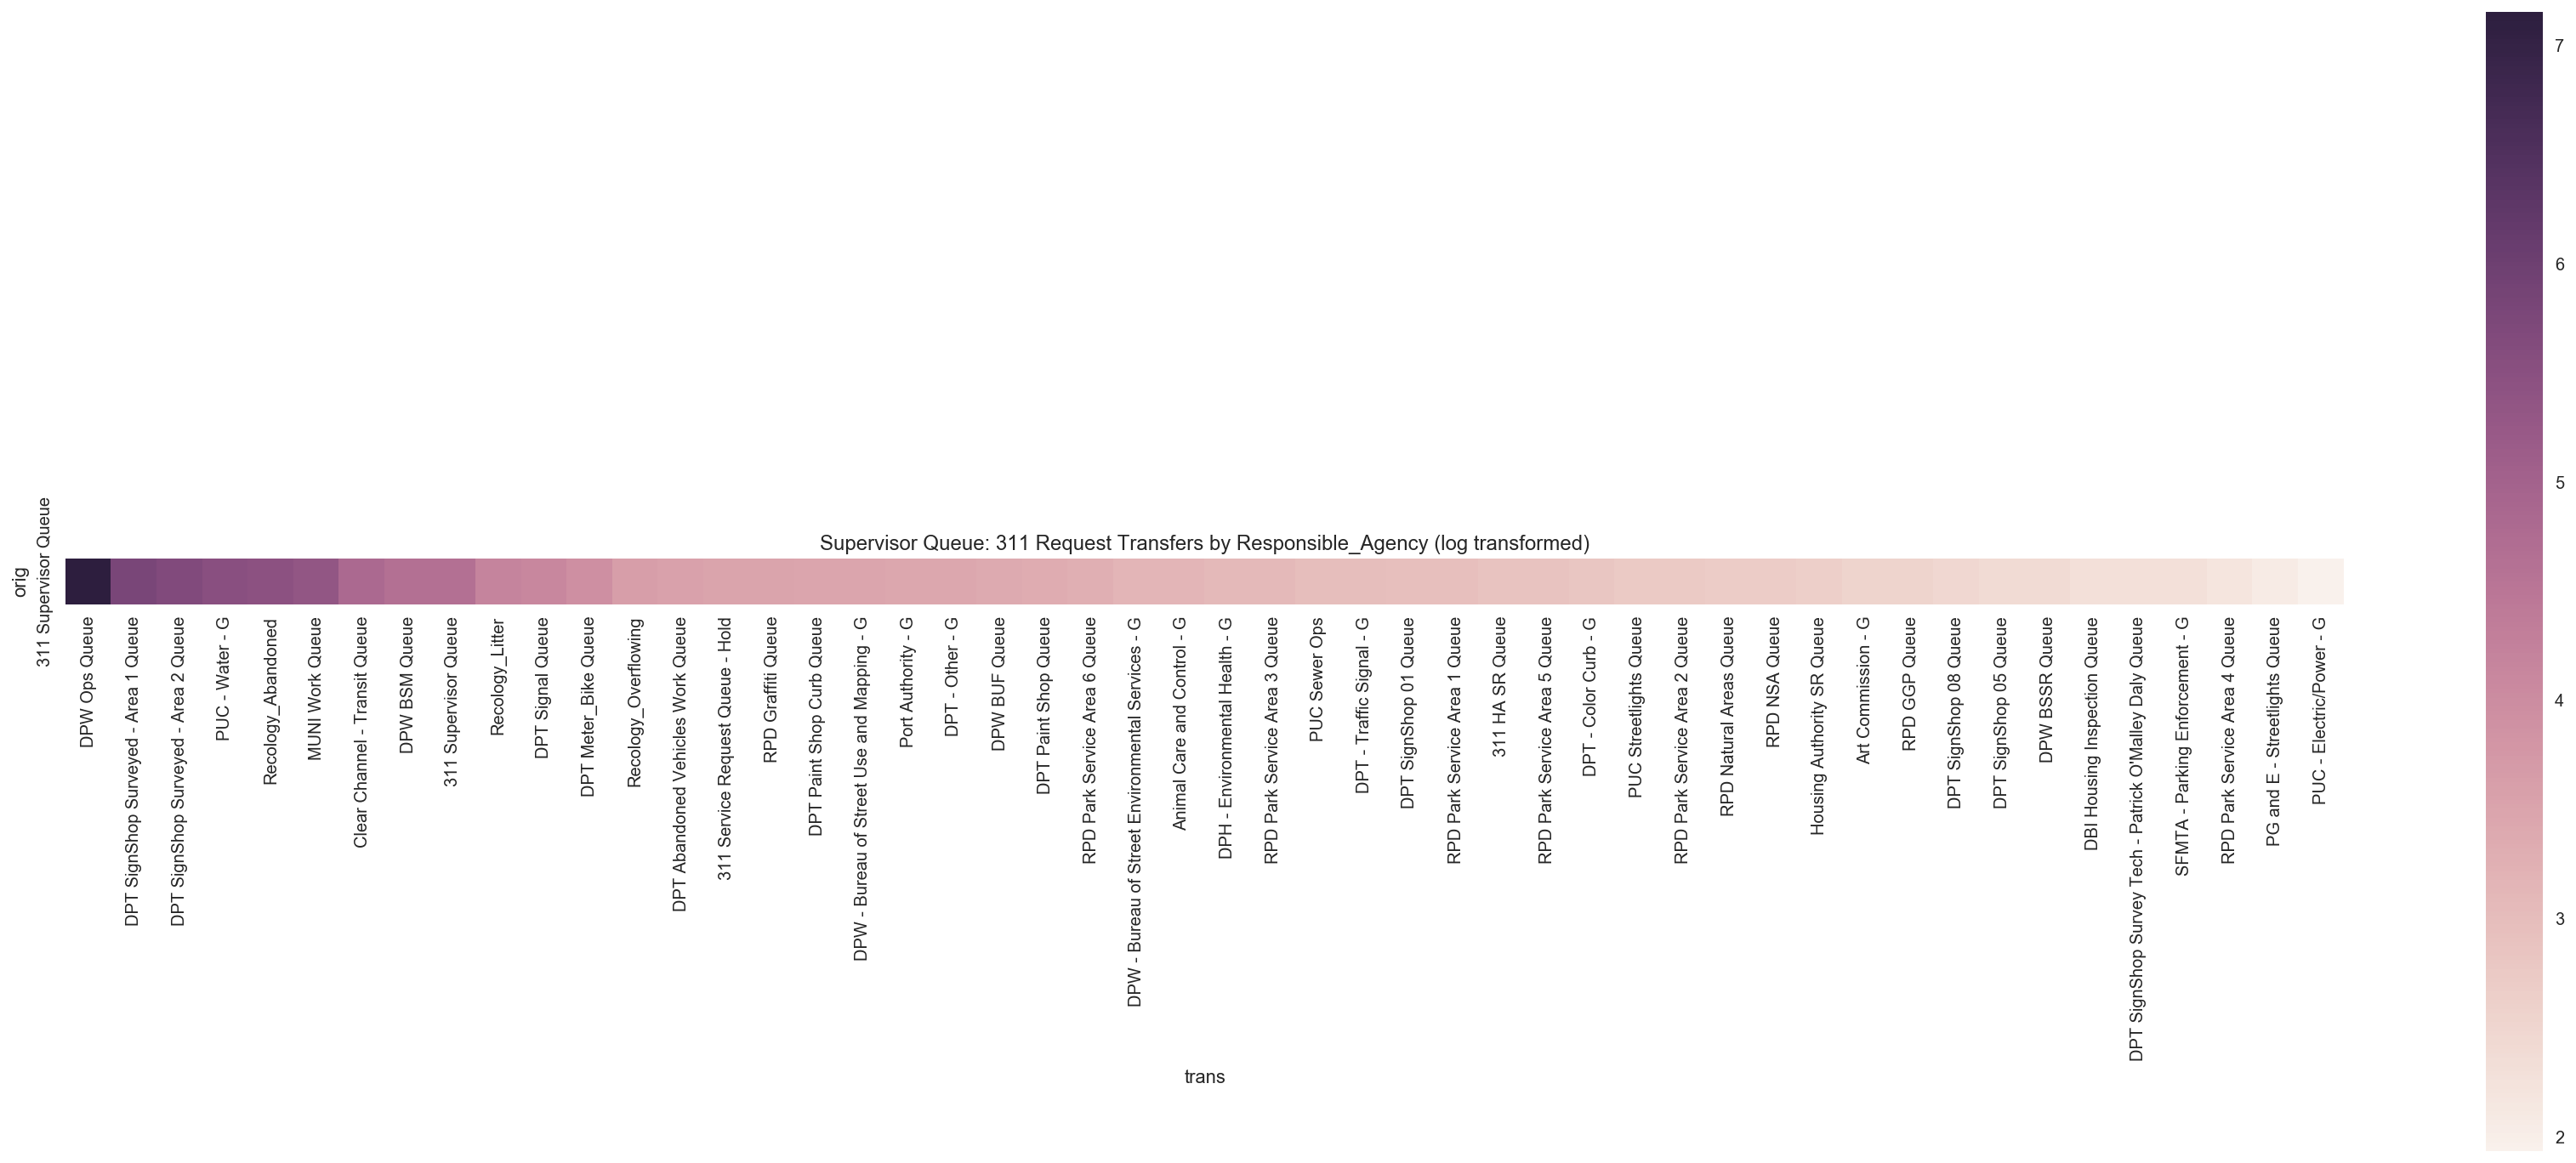

In [11]:
# supervisor queue
# df['transferred'] = df['Status_Notes'].apply(lambda x: x.find('case') >= 0) & df['Status_Notes'].apply(lambda x: x.find('transferred') >= 0) & (df['Responsible_Agency'] == '311 Supervisor Queue')
df['transferred'] = df['Status_Notes'].apply(lambda x: x.find('tran') >= 0) & (df['Responsible_Agency'] == '311 Supervisor Queue')
title_str = 'Supervisor Queue: '

print('From {} to {}:'.format(df['Opened'].min(), df['Opened'].max()))
print('For {}'.format(title_str))
print('{:,} / {:,} cases are transferred ({:.1f}%)'.format(df['transferred'].sum(), df.shape[0], (df['transferred'].sum()/df.shape[0])*100))

df_counts = plot_transfers(df, on_field=on_field,
                           log=log,
                           title_str=title_str,
                           verbose=verbose,
                           );

## Non-Supervisor Queue

From 2008-03-20 11:48:32 to 2016-03-16 00:55:50:
For Non-Supervisor Queue: 
55,740 / 1,594,511 cases are transferred (3.5%)


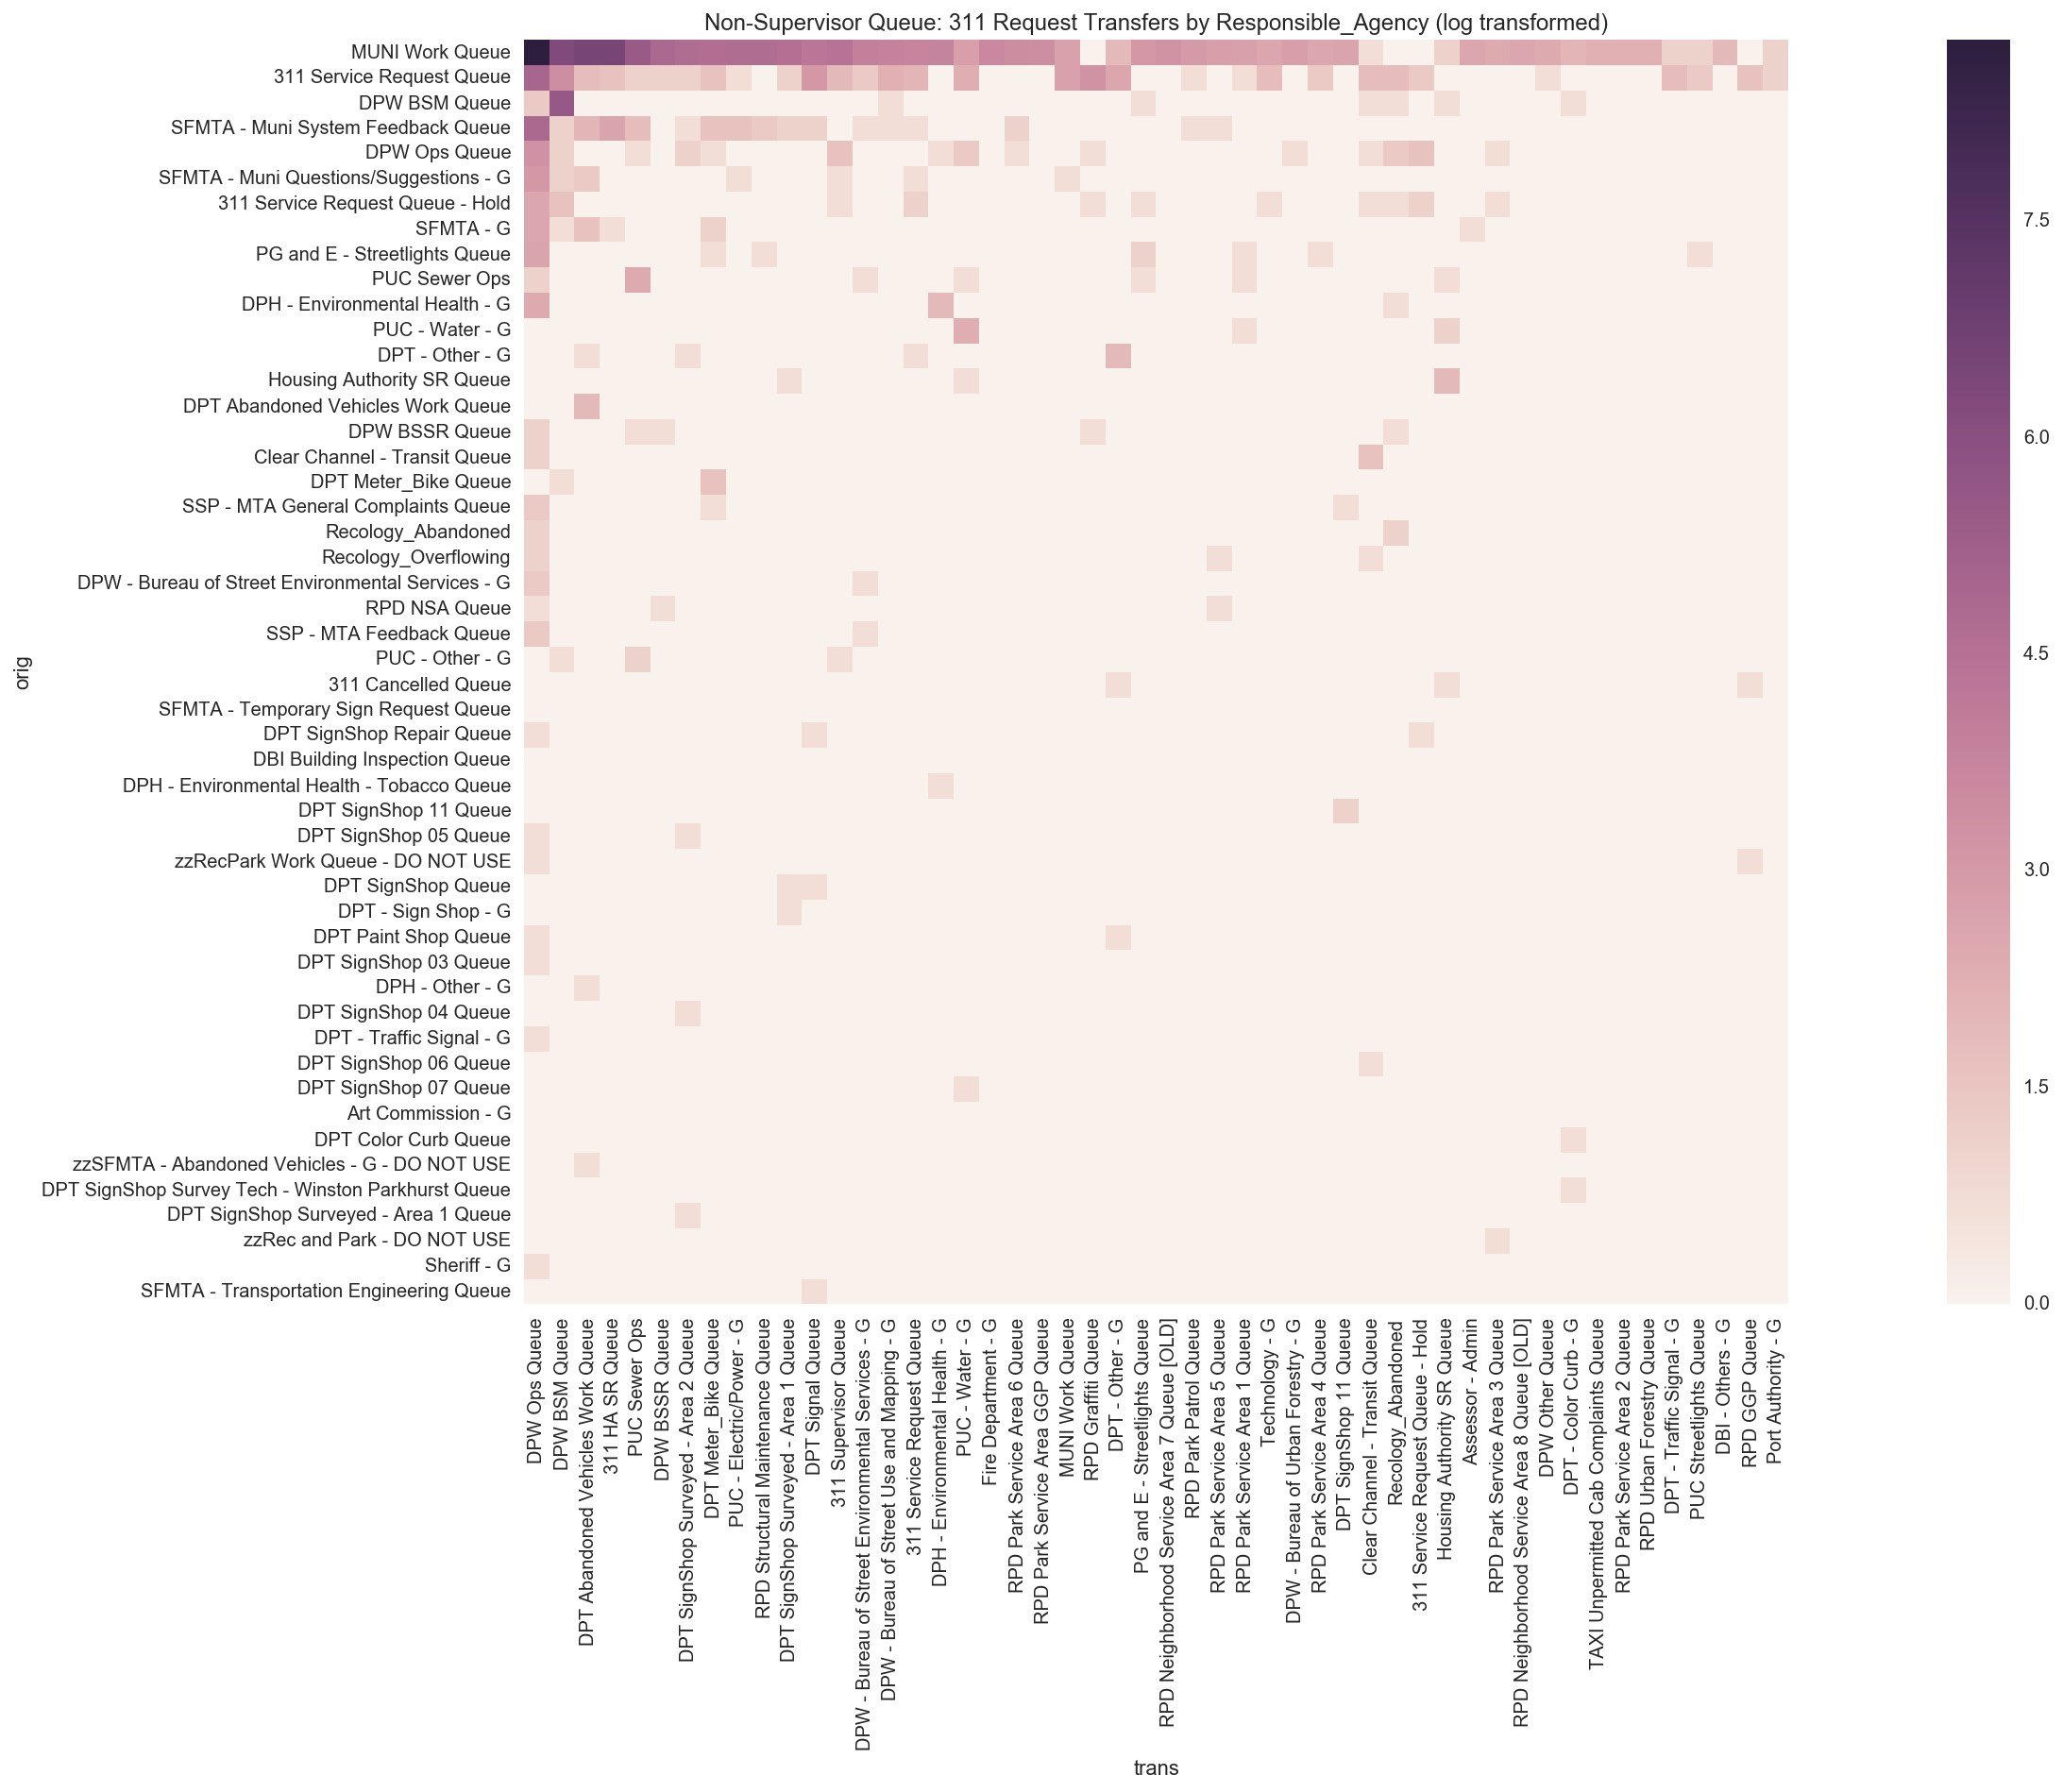

In [12]:
# # not supervisor queue
# # df['transferred'] = df['Status_Notes'].apply(lambda x: x.find('case') >= 0) & df['Status_Notes'].apply(lambda x: x.find('transferred') >= 0) & (df['Responsible_Agency'] != '311 Supervisor Queue')
df['transferred'] = df['Status_Notes'].apply(lambda x: x.find('tran') >= 0) & (df['Responsible_Agency'] != '311 Supervisor Queue')
title_str = 'Non-Supervisor Queue: '

print('From {} to {}:'.format(df['Opened'].min(), df['Opened'].max()))
print('For {}'.format(title_str))
print('{:,} / {:,} cases are transferred ({:.1f}%)'.format(df['transferred'].sum(), df.shape[0], (df['transferred'].sum()/df.shape[0])*100))

df_counts = plot_transfers(df, on_field=on_field,
                           log=log,
                           title_str=title_str,
                           verbose=verbose,
                           );